<a href="https://colab.research.google.com/github/NicolasPCS/Image-Classification/blob/main/Xception_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install livelossplot

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from keras.callbacks import ModelCheckpoint

from pathlib import Path
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16

model_name = "Xception"

#data_dir = Path('/content/drive/MyDrive/Tesis/PERUVIAN_BANKNOTES_V2/training_set')
data_dir = Path('/content/drive/MyDrive/Tesis/training_set_v3')

In [9]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.30,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

# Convertir etiquetas a enteros y luego a one-hot encoding
#train_ds = train_ds.map(lambda images, labels: (images, tf.one_hot(tf.cast(labels, tf.int32), depth=len(class_names))))
#val_ds = val_ds.map(lambda images, labels: (images, tf.one_hot(tf.cast(labels, tf.int32), depth=len(class_names))))

print(train_ds)
print(val_ds)

Found 11833 files belonging to 16 classes.
Using 8284 files for training.
Found 11833 files belonging to 16 classes.
Using 3549 files for validation.
<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>


In [ ]:
print(class_names)

('billete100_anverso_antiguo', 'billete100_anverso_nuevo', 'billete100_reverso_antiguo', 'billete100_reverso_nuevo', 'billete10_anverso_antiguo', 'billete10_anverso_nuevo', 'billete10_reverso_antiguo', 'billete10_reverso_nuevo', 'billete20_anverso_antiguo', 'billete20_anverso_nuevo', 'billete20_reverso_antiguo', 'billete20_reverso_nuevo', 'billete50_anverso_antiguo', 'billete50_anverso_nuevo', 'billete50_reverso_antiguo', 'billete50_reverso_nuevo')


In [10]:
do_fine_tuning = True #@param {type:"boolean"}

In [11]:
print("Building Xception model")

# Load the Xception model with pretrained weights, excluding the top classification layer
#base_model = tf.keras.applications.Xception(input_shape=IMAGE_SIZE + (3,), include_top=False, pooling='avg', weights='imagenet')
base_model = tf.keras.applications.Xception(input_shape=IMAGE_SIZE + (3,), include_top=False, weights='imagenet')

# Freeze the weights of the base model if not fine-tuning
if not do_fine_tuning:
    base_model.trainable = False

model = tf.keras.Sequential([
    # Use the Xception base model as the first layer
    base_model,
    # Add a dropout layer for regularization
    tf.keras.layers.Dropout(rate=0.2),
    # Add additional convolutional layers
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Add more convolutional layers if needed
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Add a global average pooling layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Add more dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # Add a dense layer for classification
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building Xception model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dropout_2 (Dropout)         (None, 10, 10, 2048)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 128)       2359424   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 256)         295168    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                         

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
  metrics=['accuracy'])

In [13]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[tl_checkpoint_1]
    #,verbose=1
    ).history

Epoch 1/5
517/517 [==============================] - ETA: 0s - loss: 1.0902 - accuracy: 0.8233
Epoch 1: val_loss improved from inf to 0.63999, saving model to tl_model_v1.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


517/517 [==============================] - 1147s 2s/step - loss: 1.0902 - accuracy: 0.8233 - val_loss: 0.6400 - val_accuracy: 0.9932
Epoch 2/5
517/517 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.9959
Epoch 2: val_loss improved from 0.63999 to 0.60276, saving model to tl_model_v1.weights.best.hdf5
517/517 [==============================] - 422s 816ms/step - loss: 0.6457 - accuracy: 0.9959 - val_loss: 0.6028 - val_accuracy: 0.9960
Epoch 3/5
517/517 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.9976
Epoch 3: val_loss improved from 0.60276 to 0.59124, saving model to tl_model_v1.weights.best.hdf5
517/517 [==============================] - 403s 780ms/step - loss: 0.6259 - accuracy: 0.9976 - val_loss: 0.5912 - val_accuracy: 0.9977
Epoch 4/5
517/517 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.9985
Epoch 4: val_loss improved from 0.59124 to 0.58852, saving model to tl_model_v1.weights.best.hdf5
517/517 [=========

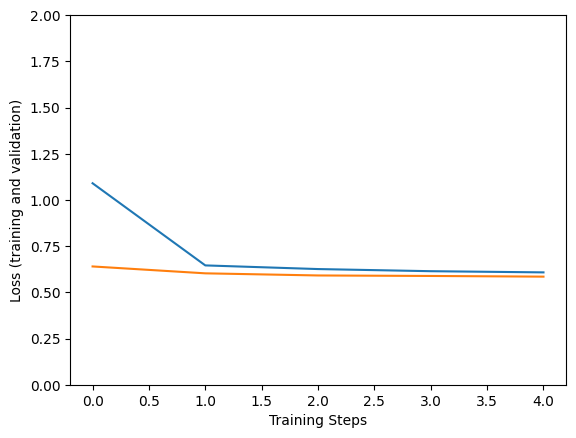

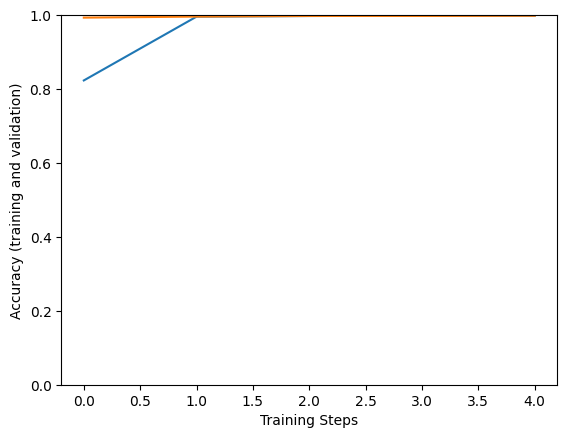

In [14]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

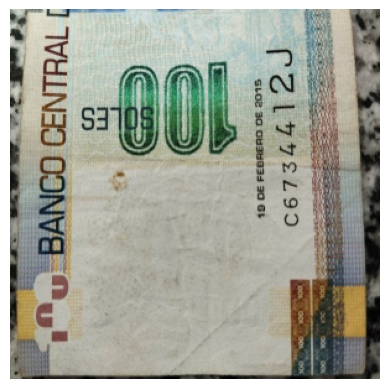

1/1 [==============================] - 1s 1s/step
True label: billete100_anverso_antiguo
Predicted label: billete100_anverso_antiguo


In [15]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [16]:
# Obtener la precisión de entrenamiento y validación del historial
train_accuracy = hist['accuracy']
val_accuracy = hist['val_accuracy']

# Imprimir la precisión de la última época
print(f"Training Accuracy: {train_accuracy[-1]*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy[-1]*100:.2f}%")

Training Accuracy: 99.87%
Validation Accuracy: 99.83%


222/222 [==============================] - 34s 148ms/step


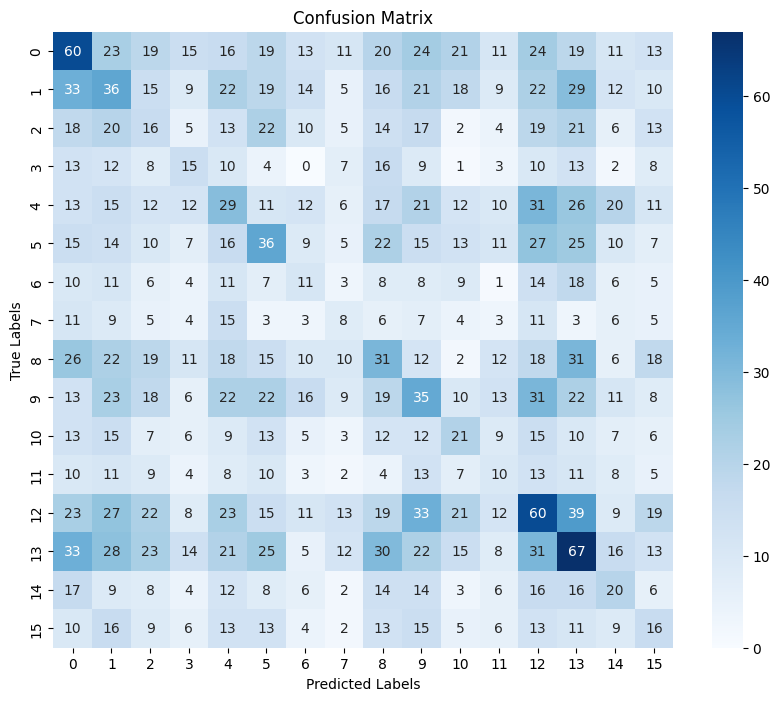

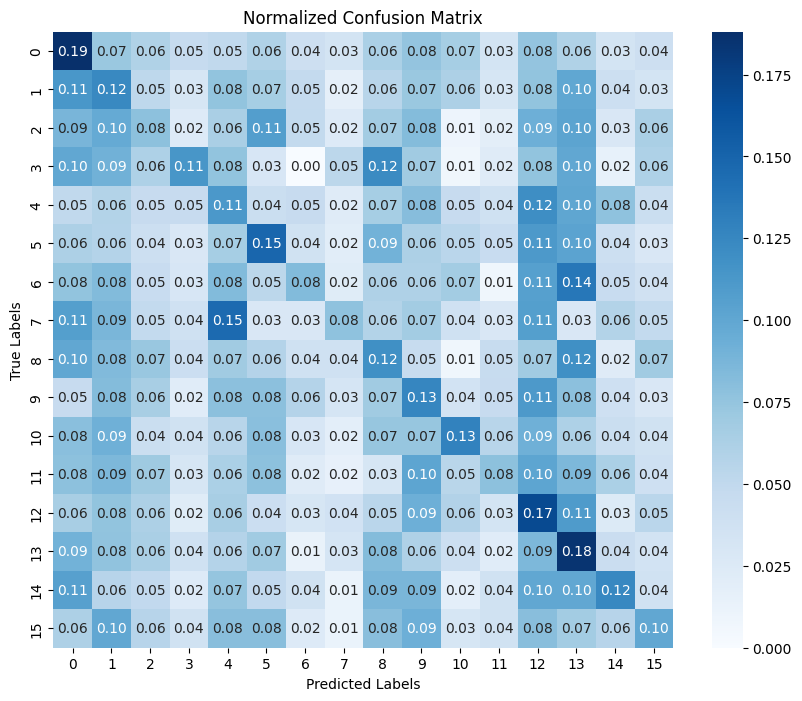

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo para el conjunto de validación
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_labels = []
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))

# Construir la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Imprimir la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Mapa de calor de la matriz de confusión normalizada
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [19]:
# Obtener las predicciones del modelo para el conjunto de validación
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_labels = []
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))

# Calcular la precisión comparando las etiquetas predichas con las etiquetas verdaderas
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy*100:.2f}%")

222/222 [==============================] - 29s 129ms/step
Accuracy: 12.76%


In [17]:
import tensorflow as tf
saved_model_path = f"/content/drive/MyDrive/Tesis/New_Trained_Models/saved_{model_name}_{train_accuracy[-1]*100:.2f}%"
tf.saved_model.save(model, saved_model_path)

model.save(f"/content/drive/MyDrive/Tesis/New_Trained_Models/{train_accuracy[-1]*100:.2f}%.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
